### 小练习

In [1]:
import tensorflow as tf
hello=tf.constant('Hello,TensorFlow')
sess=tf.Session()
print(sess.run(hello))

b'Hello,TensorFlow'


## 电影评论分类：二分类问题

使用IMDB数据集，它包含来自互联网电影数据库（IMDB）的50 000条严重两级分化分评论。
数据集被分为用于训练的25000条评论与用于测试的25 000条评论，训练集和测试集都包含50%的正面评论和50%的负面评论

#### 1、加载IMDB数据集

In [3]:
from keras.datasets import imdb
(train_data,train_labels),(test_data,test_labels)=imdb.load_data(num_words=10000)

17465344/17464789 [==============================] - 133s 8us/step


参数num_words=10 000:仅保留训练数据中前10 000个最常出现的单词。低频词被舍弃。这样得到的向量数据不会太大，便于处理。

In [33]:
print('训练数据类型：',type(train_data))
print('************************************************************************')
print('训练数据第一条评论内容：',train_data[0])
# train_data是评论组成的列表，每条评论又是单词索引组成的列表（表示一系列单词）
print('*************************************************************************')
print('训练数据评论条数：',len(train_data))
print('测试数据评论条数：',len(test_data))
print('*************************************************************************')
print('训练数据第一条标签：',train_labels[0])
#ntrain_labels是由1组成的列表，其中1代表正面（positive）
print('测试数据第一条标签：',test_labels[0])
# test_labels是由0组成的列表，其中0代表负面（negative）

训练数据类型： <class 'numpy.ndarray'>
************************************************************************
训练数据第一条评论内容： [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 2

In [48]:
# 统计列表中元素出现的次数
import pandas as pd
result=pd.value_counts(train_labels)
print('训练标签中正面/负面条数')
print(result)
print('*******************************************************************')
result1=pd.value_counts(test_labels)
print('测试标签中正面/负面条数')
print(result1)

训练标签中正面/负面条数
1    12500
0    12500
dtype: int64
*******************************************************************
测试标签中正面/负面条数
1    12500
0    12500
dtype: int64


In [12]:
# 由于限定为前10 000个最常见的单词，单词索引都不会超过10 000
max([max(sequence) for sequence in train_data])

9999

#### 2、准备数据

由于不能将整数序列直接输入神经网络。需要将列表转换为张量。

1、填充列表，使其具有相同的长度，再将列表转换成形状为（sample,word_indices）的整数张量
，然后网络第一层使用能处理这种整数张量的层（即Embedding层）

2、对列表进行one-hot编码,将其转换为0和1组成的向量。然后网络第一层可以用Dense层，它能够处理浮点数向量数据。

In [50]:
# 将整数序列编码为二进制矩阵
import numpy as np
def vectorize_sequences(sequences,dimension=10000):
    results=np.zeros((len(sequences),dimension))  # 创建一个形状为(len(sequences),dimension)的零矩阵--->25000*10000
    for i,sequence in enumerate(sequences):
        # enumerate() 函数用于将一个可遍历的数据对象(如列表、元组或字符串)组合为一个索引序列，同时列出数据和数据下标
        results[i,sequence]=1. # 将results[i]的指定索引设为1
    return results

x_train=vectorize_sequences(train_data) # 将训练数据向量化
x_test=vectorize_sequences(test_data) # 将测试数据向量化

print('训练数据二进制编码后的第一行数据：',x_train[0])
print('*****************************************************')
y_train=np.asarray(train_labels).astype('float32')
y_test=np.asarray(test_labels).astype('float32')
print('训练标签向量化：',y_train)

训练数据二进制编码后的第一行数据： [0. 1. 1. ... 0. 0. 0.]
*****************************************************
训练标签向量化： [1. 0. 0. ... 0. 1. 0.]


#### 3、构建网络

In [53]:
# 模型定义
# 选择下列架构：两个中间层，每层都有16个隐藏单元；第三层输出一个标量，预测当前评论的情感
from keras import models
from keras import layers

model=models.Sequential()
model.add(layers.Dense(16,activation='relu',input_shape=(10000,)))
model.add(layers.Dense(16,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))
# 使用sigmoid激活以输出一个0-1范围内的概率值（表示样本的目标值=1的可能性）

# 编译模型：rmsprop 优化器和binary_crossentropy 损失函数来配置模型
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])

Dense(16,activation='relu') 带有relu激活的全连接层Dense的简单堆叠

16：该层隐藏单元的个数。一个隐藏单元(hidden unit)是该层表示空间的一个维度。

每个带有relu激活的Dense层实现的张量运算：output = relu(dot(W, input) + b)

16 个隐藏单元对应的权重矩阵W 的形状为(input_dimension, 16)。与W 做点积相当于
将输入数据投影到16 维表示空间中（然后再加上偏置向量b 并应用relu 运算）。

你可以将表
示空间的维度直观地理解为“网络学习内部表示时所拥有的自由度”。隐藏单元越多（即更高维
的表示空间），网络越能够学到更加复杂的表示，但网络的计算代价也变得更大，而且可能会导
致学到不好的模式（这种模式会提高训练数据上的性能，但不会提高测试数据上的性能）。


In [55]:
# 配置优化器
from keras import optimizers
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
             loss='binary_crossentropy',
              metrics=['accuracy'])

# 使用自定义的损失和指标
from keras import losses
from keras import metrics
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
loss=losses.binary_crossentropy,
metrics=[metrics.binary_accuracy])

#### 4、 验证你的方法

In [58]:
# 留出10 000个样本作为验证集
x_val=x_train[:10000]  # 评论
partial_x_trian=x_train[10000:]

y_val=y_train[:10000]  # 标签
partial_y_train=y_train[10000:]

In [60]:
# 训练模型
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])

history=model.fit(partial_x_trian,
                 partial_y_train,
                 epochs=20,
                 batch_size=512,
                 validation_data=(x_val,y_val))

# 使用512个样本组成的小批量，将模型训练20个轮次（对x_train和y_train两个张量中的所有样本进行
# 20次迭代）。验证数据传入validation_data 参数来完成样本上的损失和精度的计算

Instructions for updating:
Use tf.cast instead.
Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 6s 411us/step - loss: 0.5395 - acc: 0.7748 - val_loss: 0.4005 - val_acc: 0.8680
Epoch 2/20
15000/15000 [==============================] - 3s 221us/step - loss: 0.3211 - acc: 0.8988 - val_loss: 0.3286 - val_acc: 0.8717
Epoch 3/20
15000/15000 [==============================] - 3s 215us/step - loss: 0.2357 - acc: 0.9245 - val_loss: 0.2872 - val_acc: 0.8863
Epoch 4/20
15000/15000 [==============================] - 3s 216us/step - loss: 0.1849 - acc: 0.9389 - val_loss: 0.2746 - val_acc: 0.8905
Epoch 5/20
15000/15000 [==============================] - 3s 218us/step - loss: 0.1529 - acc: 0.9512 - val_loss: 0.3000 - val_acc: 0.8803
Epoch 6/20
15000/15000 [==============================] - 3s 221us/step - loss: 0.1234 - acc: 0.9621 - val_loss: 0.2886 - val_acc: 0.8862
Epoch 7/20
15000/15000 [==============================] - 3s 227us/step - 

##### fit(x, y, batch_size=32, epochs=10, validation_split=0.0, validation_data=None)

x:输入数据

y：标签

batch_size:指定进行梯度下降时每个batch包含的样本数。训练时一个batch的样本会被计算一次梯度下降，使目标函数优化一步。

epochs:训练的总轮数。训练将在达到该epoch值时停止

validation_split：0~1之间的浮点数，用来指定训练集的一定比例数据作为验证集。验证集将不参与训练，并在每个epoch结束后测试的模型的指标，如损失函数、精确度等

validation_data：形式为（X，y）的tuple，是指定的验证集。此参数将覆盖validation_spilt。

##### 字典中包含4 个条目，对应训练过程和验证过程中监控的指标

#### 5、绘制图形

In [62]:
# 调用model.fit()返回一个History对象。这个对象有一个成员history，它是一个字典，包含训练过程中的所有数据
history_dict=history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

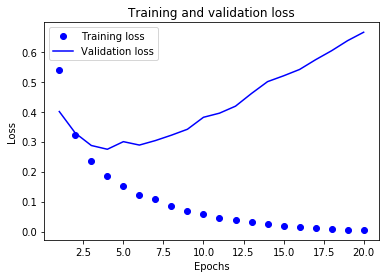

In [65]:
# 绘制训练损失和验证损失
import matplotlib.pyplot as plt
history_dict=history.history
loss_values=history_dict['loss']
val_loss_values=history_dict['val_loss']

epochs=range(1,len(loss_values)+1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

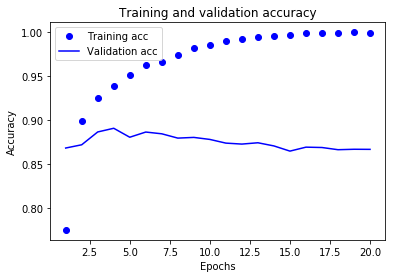

In [66]:
# 绘制训练精度和验证精度
# plt.clf()  清空图像
acc = history_dict['acc']
val_acc = history_dict['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

如你所见，训练损失每轮都在降低，训练精度每轮都在提升。这就是梯度下降优化的预期结果——你想要最小化的量随着每次迭代越来越小。但验证损失和验证精度并非如此：它们似乎在第四轮达到最佳值。这就是我们之前警告过的一种情况：模型在训练数据上的表现越来越好，但在前所未见的数据上不一定表现得越来越好。准确地说，你看到的是过拟合（overfit）：在第二轮之后，你对训练数据过度优化，最终学到的表示仅针对于训练数据，无法泛化到训练集之外的数据。

In [68]:
# 从头开始重新讯训练一个模型
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=['accuracy'])
model.fit(x_train, y_train, epochs=4, batch_size=512)

Epoch 1/4
25000/25000 [==============================] - 5s 210us/step - loss: 0.4751 - acc: 0.8217
Epoch 2/4
25000/25000 [==============================] - 4s 143us/step - loss: 0.2658 - acc: 0.9096
Epoch 3/4
25000/25000 [==============================] - 3s 137us/step - loss: 0.1984 - acc: 0.9298
Epoch 4/4
25000/25000 [==============================] - 3s 140us/step - loss: 0.1677 - acc: 0.9403


In [70]:
results = model.evaluate(x_test, y_test)
results #这种相当简单的方法得到了88% 的精度

25000/25000 [==============================] - 9s 377us/step


[0.3236889276695252, 0.8734]

#### 6、使用训练好的网络在新数据上生成预测结果

In [71]:
model.predict(x_test)

array([[0.13910061],
       [0.9996963 ],
       [0.29169148],
       ...,
       [0.07171836],
       [0.04268771],
       [0.469887  ]], dtype=float32)